In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName('heart-disease-mining-clean') \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 02:03:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_dirt= spark.read.csv('Datasets/heart_2022_with_nans - with dirt.csv', header=True, inferSchema=True)
#for column in df_dirt.columns:
    #null_count = df_dirt.filter(df_dirt[column].isNull()).count()
    #print(f"Column '{column}': {null_count} null values")

In [3]:
# use groupby to calculate value counts for 'SmokerStatus'
smoker_status_counts = df_dirt.groupBy('SmokerStatus').count().orderBy('count', ascending=False)
smoker_status_counts.show()

+--------------------+------+
|        SmokerStatus| count|
+--------------------+------+
|        Never smoked|245955|
|       Former smoker|113769|
|Current smoker - ...| 36003|
|                null| 35462|
|Current smoker - ...| 13938|
|     Previous smoker|     5|
+--------------------+------+



In [4]:
Age_counts = df_dirt.groupBy('AgeCategory').count().orderBy('count', ascending=False)
Age_counts.show()

+---------------+-----+
|    AgeCategory|count|
+---------------+-----+
|   Age 65 to 69|47098|
|   Age 60 to 64|44511|
|   Age 70 to 74|43472|
|   Age 55 to 59|36821|
|Age 80 or older|36250|
|   Age 50 to 54|33644|
|   Age 75 to 79|32516|
|   Age 40 to 44|29942|
|   Age 45 to 49|28531|
|   Age 35 to 39|28526|
|   Age 18 to 24|26941|
|   Age 30 to 34|25806|
|   Age 25 to 29|21989|
|           null| 9079|
|             78|    1|
|             67|    1|
|             76|    1|
|             88|    1|
|             34|    1|
|             26|    1|
+---------------+-----+



In [5]:
df_dirt.describe('WeightInKilograms').show()

+-------+-----------------+
|summary|WeightInKilograms|
+-------+-----------------+
|  count|           403054|
|   mean|83.10065152559405|
| stddev|27.15749401703654|
|    min|            22.68|
|    max|          10659.0|
+-------+-----------------+



In [6]:
#data cleaning
columns_to_exclude = [
    'State', 'LastCheckupTime', 'ChestScan', 'GeneralHealth',
    'PhysicalHealthDays', 'MentalHealthDays', 'RemovedTeeth',
    'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
    'DifficultyConcentrating', 'DifficultyWalking',
    'DifficultyDressingBathing', 'DifficultyErrands',
    'HeightInMeters', 'WeightInKilograms'  
]
df_03 = df_dirt.drop(*columns_to_exclude)

In [7]:
df_03.columns

['Sex',
 'PhysicalActivities',
 'SleepHours',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'SmokerStatus',
 'ECigaretteUsage',
 'RaceEthnicityCategory',
 'AgeCategory',
 'BMI',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [8]:
from pyspark.sql import functions as F

# Create a list of columns with their respective null counts using isnull
null_counts = df_03.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df_03.columns])
null_counts_dict = null_counts.collect()[0].asDict()
for column, null_count in null_counts_dict.items():
    print(f"{column}: {null_count}")

Sex: 0
PhysicalActivities: 1093
SleepHours: 5453
HadHeartAttack: 3065
HadAngina: 4405
HadStroke: 1557
HadAsthma: 1773
HadSkinCancer: 3143
HadCOPD: 2219
HadDepressiveDisorder: 2812
HadKidneyDisease: 1926
HadArthritis: 2633
HadDiabetes: 1087
SmokerStatus: 35462
ECigaretteUsage: 35660
RaceEthnicityCategory: 14057
AgeCategory: 9079
BMI: 48806
AlcoholDrinkers: 46574
HIVTesting: 66127
FluVaxLast12: 47121
PneumoVaxEver: 77040
TetanusLast10Tdap: 82516
HighRiskLastYear: 50623
CovidPos: 50764


In [9]:
# Count the total number of rows in the DataFrame
total_count = df_03.count()

# Calculate the number of null values and the percentage of nulls for each column
null_percentage = df_03.select([
    ((F.count(F.when(F.col(c).isNull(), c)) / total_count) * 100).alias(c)
    for c in df_03.columns
])

null_percentage_dict = null_percentage.collect()[0].asDict()

for column, percentage in null_percentage_dict.items():
    print(f"{column}: {percentage:.2f}%")

Sex: 0.00%
PhysicalActivities: 0.25%
SleepHours: 1.23%
HadHeartAttack: 0.69%
HadAngina: 0.99%
HadStroke: 0.35%
HadAsthma: 0.40%
HadSkinCancer: 0.71%
HadCOPD: 0.50%
HadDepressiveDisorder: 0.63%
HadKidneyDisease: 0.43%
HadArthritis: 0.59%
HadDiabetes: 0.24%
SmokerStatus: 7.97%
ECigaretteUsage: 8.01%
RaceEthnicityCategory: 3.16%
AgeCategory: 2.04%
BMI: 10.96%
AlcoholDrinkers: 10.46%
HIVTesting: 14.86%
FluVaxLast12: 10.59%
PneumoVaxEver: 17.31%
TetanusLast10Tdap: 18.54%
HighRiskLastYear: 11.37%
CovidPos: 11.40%


In [10]:
from pyspark.sql import functions as F

# List of categorical columns to check for null values
categorical_columns = [
    'Sex', 'PhysicalActivities', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 
    'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 
    'HadDiabetes', 'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory', 
    'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 
    'HighRiskLastYear', 'CovidPos'
]

df_03_cleaned_01= df_03.na.drop(subset=categorical_columns)

# Count null values in each column after dropping rows
null_counts = df_03_cleaned_01.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df_03_cleaned_01.columns])
null_counts_dict = null_counts.collect()[0].asDict()

# Print the null counts for each column
for column, null_count in null_counts_dict.items():
    print(f"{column}: {null_count}")


Sex: 0
PhysicalActivities: 0
SleepHours: 2221
HadHeartAttack: 0
HadAngina: 0
HadStroke: 0
HadAsthma: 0
HadSkinCancer: 0
HadCOPD: 0
HadDepressiveDisorder: 0
HadKidneyDisease: 0
HadArthritis: 0
HadDiabetes: 0
SmokerStatus: 0
ECigaretteUsage: 0
RaceEthnicityCategory: 0
AgeCategory: 0
BMI: 15757
AlcoholDrinkers: 0
HIVTesting: 0
FluVaxLast12: 0
PneumoVaxEver: 0
TetanusLast10Tdap: 0
HighRiskLastYear: 0
CovidPos: 0


In [11]:

from pyspark.sql.functions import mean

# Calculate the mean of BMI and SleepHours
bmi_mean = df_03_cleaned_01.select(mean('BMI')).first()[0]
sleep_hours_mean = df_03_cleaned_01.select(mean('SleepHours')).first()[0]

# Replace null values with the mean
df_03_cleaned_02 = df_03_cleaned_01.fillna({'BMI': bmi_mean, 'SleepHours': sleep_hours_mean})

# Verify the changes by counting null values again
null_counts = df_03_cleaned_02.select([F.count(F.when(F.col(c).isNull(), 1)).alias(c) for c in df_03_cleaned_02.columns])
null_counts_dict = null_counts.collect()[0].asDict()

# Print the null counts for each column
for column, null_count in null_counts_dict.items():
    print(f"{column}: {null_count}")


Sex: 0
PhysicalActivities: 0
SleepHours: 0
HadHeartAttack: 0
HadAngina: 0
HadStroke: 0
HadAsthma: 0
HadSkinCancer: 0
HadCOPD: 0
HadDepressiveDisorder: 0
HadKidneyDisease: 0
HadArthritis: 0
HadDiabetes: 0
SmokerStatus: 0
ECigaretteUsage: 0
RaceEthnicityCategory: 0
AgeCategory: 0
BMI: 0
AlcoholDrinkers: 0
HIVTesting: 0
FluVaxLast12: 0
PneumoVaxEver: 0
TetanusLast10Tdap: 0
HighRiskLastYear: 0
CovidPos: 0


In [12]:
bmi_lower_bound = df_03_cleaned_02.approxQuantile("BMI", [0.0025], 0.0)[0]
bmi_upper_bound = df_03_cleaned_02.approxQuantile("BMI", [0.9975], 0.0)[0]

sleep_lower_bound = df_03_cleaned_02.approxQuantile("SleepHours", [0.0025], 0.0)[0]
sleep_upper_bound = df_03_cleaned_02.approxQuantile("SleepHours", [0.9975], 0.0)[0]

# Filter the dataframe based on the calculated bounds
df_03_cleaned_03 = df_03_cleaned_02.filter(
    (F.col('BMI') >= bmi_lower_bound) & (F.col('BMI') <= bmi_upper_bound) &
    (F.col('SleepHours') >= sleep_lower_bound) & (F.col('SleepHours') <= sleep_upper_bound)
)

# Show the number of rows and columns after filtering
print(f"Number of rows and columns before filtering: {df_03_cleaned_02.count()} rows x {len(df_03_cleaned_02.columns)} columns")
print(f"Number of rows and columns after filtering: {df_03_cleaned_03.count()} rows x {len(df_03_cleaned_03.columns)} columns")



Number of rows and columns before filtering: 288444 rows x 25 columns


Number of rows and columns after filtering: 285788 rows x 25 columns


In [13]:
df_03_cleaned_03.describe('BMI').show()

+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|            285788|
|   mean|28.596861735345282|
| stddev| 6.059249795657394|
|    min|             16.24|
|    max|             57.39|
+-------+------------------+



In [14]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# Function to reclassify numerical ages to age categories
def reclassify_age(age):
    if age <= 25:
        return 'Age 18 to 24'
    elif 25 < age <= 30:
        return 'Age 25 to 29'
    elif 30 < age <= 35:
        return 'Age 30 to 34'
    elif 35 < age <= 40:
        return 'Age 35 to 39'
    elif 40 < age <= 45:
        return 'Age 40 to 44'
    elif 45 < age <= 50:
        return 'Age 45 to 49'
    elif 50 < age <= 55:
        return 'Age 50 to 54'
    elif 55 < age <= 60:
        return 'Age 55 to 59'
    elif 60 < age <= 65:
        return 'Age 60 to 64'
    elif 65 < age <= 70:
        return 'Age 65 to 69'
    elif 70 < age <= 75:
        return 'Age 70 to 74'
    elif 75 < age <= 80:
        return 'Age 75 to 79'
    else:
        return 'Age 80 or older'

# UDF to apply the reclassification function
reclassify_age_udf = F.udf(lambda x: reclassify_age(int(x)) if x.isdigit() else x, StringType())
df_03_cleaned_04 = df_03_cleaned_03.withColumn('AgeCategory', reclassify_age_udf(F.col('AgeCategory')))

# Show the reclassified age category
df_03_cleaned_04.select('AgeCategory').distinct().show()


+---------------+
|    AgeCategory|
+---------------+
|   Age 45 to 49|
|   Age 25 to 29|
|   Age 70 to 74|
|   Age 55 to 59|
|   Age 18 to 24|
|   Age 60 to 64|
|   Age 50 to 54|
|   Age 35 to 39|
|   Age 30 to 34|
|Age 80 or older|
|   Age 40 to 44|
|   Age 75 to 79|
|   Age 65 to 69|
+---------------+



In [15]:
# Function to reclassify smoker status
def reclassify_smoker(status):
    if status == 'Previous smoker':
        return 'Former smoker'
    else:
        return status

# UDF to apply the reclassification function
reclassify_smoker_udf = F.udf(lambda x: reclassify_smoker(x), StringType())

# Apply the UDF to reclassify smoker status
df_03_cleaned_05 = df_03_cleaned_04.withColumn('SmokerStatus', reclassify_smoker_udf(F.col('SmokerStatus')))

# Show the reclassified DataFrame
df_03_cleaned_05.select('SmokerStatus').distinct().show()


+--------------------+
|        SmokerStatus|
+--------------------+
|        Never smoked|
|Current smoker - ...|
|       Former smoker|
|Current smoker - ...|
+--------------------+



In [16]:
from pyspark.sql import functions as F

# Function to determine if a respondent had heart disease
def had_heart_disease(had_heart_attack, had_angina):
    return 'Yes' if had_heart_attack == 'Yes' or had_angina == 'Yes' else 'No'

# Register the function as a UDF
had_heart_disease_udf = F.udf(lambda x, y: had_heart_disease(x, y), StringType())

# Apply the UDF to create the HadHeartDisease column
df_03_cleaned_06 = df_03_cleaned_05.withColumn('HadHeartDisease', had_heart_disease_udf(F.col('HadHeartAttack'), F.col('HadAngina')))

# Show the result
df_03_cleaned_06.select('HadHeartAttack', 'HadAngina', 'HadHeartDisease').show()


+--------------+---------+---------------+
|HadHeartAttack|HadAngina|HadHeartDisease|
+--------------+---------+---------------+
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|           Yes|       No|            Yes|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|            No|       No|             No|
|           Yes|      Yes|            Yes|
|            No|       No|             No|
|            No|      Yes|            Yes|
|            No|       No|             No|
|           Yes|      Yes|            Yes|
+----------

Traceback (most recent call last):
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 663, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [17]:
# Addition two: EcigaFlag column

# Function to determine the e-cigarette usage flag
def ecig_new(response):
    if response in ["Use them every day", "Use them some days"]:
        return "Yes"
    else:
        return "No"

# Register the function as a UDF
ecig_new_udf = F.udf(lambda x: ecig_new(x), StringType())

# Apply the UDF to create the EcigaFlag column
df_03_cleaned_07 = df_03_cleaned_06.withColumn('EcigaFlag', ecig_new_udf(F.col('ECigaretteUsage')))

# Show the result
df_03_cleaned_07.select('ECigaretteUsage', 'EcigaFlag').show()



+--------------------+---------+
|     ECigaretteUsage|EcigaFlag|
+--------------------+---------+
|Not at all (right...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Not at all (right...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
|Not at all (right...|       No|
|Never used e-ciga...|       No|
|Never used e-ciga...|       No|
+--------------------+---------+
only showing top 20 rows



In [18]:
# Addition three: Smoked column
# Function to determine if the person has smoked
def smoker_new(status):
    if status == "Never smoked":
        return "No"
    else:
        return "Yes"

# Register the function as a UDF
smoker_new_udf = F.udf(lambda x: smoker_new(x), StringType())

# Apply the UDF to create the Smoked column
df_03_cleaned_08 = df_03_cleaned_07.withColumn('Smoked', smoker_new_udf(F.col('SmokerStatus')))

# Show the result
df_03_cleaned_08.select('SmokerStatus', 'Smoked').show()


+--------------------+------+
|        SmokerStatus|Smoked|
+--------------------+------+
|        Never smoked|    No|
|        Never smoked|    No|
|        Never smoked|    No|
|        Never smoked|    No|
|       Former smoker|   Yes|
|        Never smoked|    No|
|       Former smoker|   Yes|
|        Never smoked|    No|
|        Never smoked|    No|
|       Former smoker|   Yes|
|        Never smoked|    No|
|       Former smoker|   Yes|
|        Never smoked|    No|
|        Never smoked|    No|
|        Never smoked|    No|
|Current smoker - ...|   Yes|
|        Never smoked|    No|
|Current smoker - ...|   Yes|
|       Former smoker|   Yes|
|        Never smoked|    No|
+--------------------+------+
only showing top 20 rows



In [19]:
# Addition four: Diabetic column
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
# Function to determine if the person is diabetic
def diabetes_new(status):
    if status == 'Yes' or status == 'Yes, but only during pregnancy (female)':
        return 'Yes'
    else:
        return 'No'

# Register the function as a UDF
diabetes_new_udf = udf(diabetes_new, StringType())

# Apply the UDF to create the Diabetic column
df_03_cleaned_09 = df_03_cleaned_08.withColumn('Diabetic', diabetes_new_udf(F.col('HadDiabetes')))

# Show the result
df_03_cleaned_09.select('HadDiabetes', 'Diabetic').show()



+-----------+--------+
|HadDiabetes|Diabetic|
+-----------+--------+
|        Yes|     Yes|
|         No|      No|
|         No|      No|
|        Yes|     Yes|
|         No|      No|
|         No|      No|
|         No|      No|
|         No|      No|
|         No|      No|
|         No|      No|
|         No|      No|
|        Yes|     Yes|
|         No|      No|
|         No|      No|
|         No|      No|
|        Yes|     Yes|
|         No|      No|
|         No|      No|
|        Yes|     Yes|
|         No|      No|
+-----------+--------+
only showing top 20 rows



In [20]:
df_03_cleaned_09.select('Diabetic').distinct().show()

+--------+
|Diabetic|
+--------+
|      No|
|     Yes|
+--------+



In [21]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to determine if the person had Covid
def had_covid(status):
    if status == 'Yes' or status == 'Tested positive using home test without a health professional':
        return 'Yes'
    else:
        return 'No'

# Register the function as a UDF
had_covid_udf = udf(had_covid, StringType())

# Apply the UDF to create the HadCovid column
df_03_cleaned_10 = df_03_cleaned_09.withColumn('HadCovid', had_covid_udf(F.col('CovidPos')))

# Show the result
df_03_cleaned_10.select('CovidPos', 'HadCovid').show()


+--------+--------+
|CovidPos|HadCovid|
+--------+--------+
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
|     Yes|     Yes|
|      No|      No|
|      No|      No|
|      No|      No|
|     Yes|     Yes|
|      No|      No|
|      No|      No|
|      No|      No|
|      No|      No|
+--------+--------+
only showing top 20 rows



In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to determine if the person had tetanus
def had_tetanus(status):
    if status == 'Yes, received tetanus shot but not sure what type' or status == 'Yes, received Tdap':
        return 'Yes'
    else:
        return 'No'

# Register the function as a UDF
had_tetanus_udf = udf(had_tetanus, StringType())

# Apply the UDF to create the HadTetanus column
df_03_cleaned_11 = df_03_cleaned_10.withColumn('HadTetanus', had_tetanus_udf(F.col('TetanusLast10Tdap')))

# Show the result
df_03_cleaned_11.select('TetanusLast10Tdap', 'HadTetanus').show()


+--------------------+----------+
|   TetanusLast10Tdap|HadTetanus|
+--------------------+----------+
|Yes, received tet...|       Yes|
|No, did not recei...|        No|
|No, did not recei...|        No|
|No, did not recei...|        No|
|No, did not recei...|        No|
|Yes, received tet...|       Yes|
|Yes, received tet...|       Yes|
|Yes, received tet...|       Yes|
|Yes, received tet...|       Yes|
|No, did not recei...|        No|
|Yes, received tet...|       Yes|
|No, did not recei...|        No|
|No, did not recei...|        No|
|  Yes, received Tdap|       Yes|
|Yes, received tet...|       Yes|
|Yes, received tet...|       Yes|
|No, did not recei...|        No|
|No, did not recei...|        No|
|No, did not recei...|        No|
|Yes, received tet...|       Yes|
+--------------------+----------+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to reclassify race and ethnicity
def race_ethnicity(category):
    if category == 'White only, Non-Hispanic':
        return 'White'
    elif category == 'Black only, Non-Hispanic':
        return 'Black'
    elif category == 'Other race only, Non-Hispanic':
        return 'Other'
    elif category == 'Hispanic':
        return 'Hispanic'
    elif category == 'Multiracial, Non-Hispanic':
        return 'Multiracial'
    else:
        return category

# Register the function as a UDF
race_ethnicity_udf = udf(race_ethnicity, StringType())

# Apply the UDF to create the RaceEth column
df_03_cleaned_12 = df_03_cleaned_11.withColumn('RaceEth', race_ethnicity_udf(F.col('RaceEthnicityCategory')))

# Show the result
df_03_cleaned_12.select('RaceEthnicityCategory', 'RaceEth').show()


+---------------------+-------+
|RaceEthnicityCategory|RaceEth|
+---------------------+-------+
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| Black only, Non-H...|  Black|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| Black only, Non-H...|  Black|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| Black only, Non-H...|  Black|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
| White only, Non-H...|  White|
+---------------------+-------+
only showing top 20 rows



In [24]:
# 3.5 Data formatting
cleaned_df = df_03_cleaned_12
# Columns to drop
columns_to_drop = ["ECigaretteUsage", "SmokerStatus", 
                   "HadHeartAttack", "HadAngina", "HadDiabetes", "CovidPos", "TetanusLast10Tdap", "RaceEthnicityCategory"]

# Drop the columns
formatted_df_01 = cleaned_df.drop(*columns_to_drop)

# Show the schema to verify columns are dropped
formatted_df_01.printSchema()


root
 |-- Sex: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: integer (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- BMI: double (nullable = false)
 |-- AlcoholDrinkers: string (nullable = true)
 |-- HIVTesting: string (nullable = true)
 |-- FluVaxLast12: string (nullable = true)
 |-- PneumoVaxEver: string (nullable = true)
 |-- HighRiskLastYear: string (nullable = true)
 |-- HadHeartDisease: string (nullable = true)
 |-- EcigaFlag: string (nullable = true)
 |-- Smoked: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- HadCovid: string (nullable = true)
 |-- HadTetanus: string (nullable = true)
 |-

In [25]:
from pyspark.ml.feature import StringIndexer

# Define all categorical columns, including binary ones
categorical_columns = [
    'Sex', 'PhysicalActivities', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder',
    'HadKidneyDisease', 'HadArthritis', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
    'HighRiskLastYear', 'HadHeartDisease', 'EcigaFlag', 'Smoked', 'Diabetic', 'HadCovid', 'HadTetanus',
    'AgeCategory', 'RaceEth'
]

# Apply StringIndexer for all categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column + "_Index") for column in categorical_columns]

# Fit the StringIndexer models and transform the data
for indexer in indexers:
    formatted_df_01 = indexer.fit(formatted_df_01).transform(formatted_df_01)

# Drop the original categorical columns and rename the indexed columns
for column in categorical_columns:
    formatted_df_01 = formatted_df_01.drop(column).withColumnRenamed(column + "_Index", column)

# Show the schema to confirm changes
formatted_df_01.printSchema()

# Verify the first few rows to confirm changes
formatted_df_01.show()




root
 |-- SleepHours: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- Sex: double (nullable = false)
 |-- PhysicalActivities: double (nullable = false)
 |-- HadStroke: double (nullable = false)
 |-- HadAsthma: double (nullable = false)
 |-- HadSkinCancer: double (nullable = false)
 |-- HadCOPD: double (nullable = false)
 |-- HadDepressiveDisorder: double (nullable = false)
 |-- HadKidneyDisease: double (nullable = false)
 |-- HadArthritis: double (nullable = false)
 |-- AlcoholDrinkers: double (nullable = false)
 |-- HIVTesting: double (nullable = false)
 |-- FluVaxLast12: double (nullable = false)
 |-- PneumoVaxEver: double (nullable = false)
 |-- HighRiskLastYear: double (nullable = false)
 |-- HadHeartDisease: double (nullable = false)
 |-- EcigaFlag: double (nullable = false)
 |-- Smoked: double (nullable = false)
 |-- Diabetic: double (nullable = false)
 |-- HadCovid: double (nullable = false)
 |-- HadTetanus: double (nullable = false)
 |-- AgeCategory: double (

In [26]:
formatted_df_01.groupBy('HadHeartDisease').count().show()

+---------------+------+
|HadHeartDisease| count|
+---------------+------+
|            0.0|260329|
|            1.0| 25459|
+---------------+------+



In [27]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

formatted_df = formatted_df_01
# Combine all features into a single vector column
feature_columns = [col for col in formatted_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(formatted_df)

# Fit the RandomForestClassifier
rf = RandomForestClassifier(labelCol='HadHeartDisease', featuresCol='features', numTrees=100)
rf_model = rf.fit(formatted_df)

# Extract Feature Importances
importances = rf_model.featureImportances
feature_importances = sorted(zip(importances, feature_columns), reverse=True)

# Display Feature Importances in descending order
print("Feature Importance:")
for importance, feature in feature_importances:
    print(f"{feature}: {importance:.4f}")



Feature Importance:
HadStroke: 0.2547
AgeCategory: 0.2156
HadCOPD: 0.1520
PneumoVaxEver: 0.1068
Diabetic: 0.0893
HadKidneyDisease: 0.0749
HadArthritis: 0.0514
Sex: 0.0191
Smoked: 0.0148
AlcoholDrinkers: 0.0077
SleepHours: 0.0040
HadSkinCancer: 0.0036
PhysicalActivities: 0.0024
BMI: 0.0008
HadAsthma: 0.0007
RaceEth: 0.0007
HadDepressiveDisorder: 0.0005
HIVTesting: 0.0003
FluVaxLast12: 0.0002
EcigaFlag: 0.0001
HighRiskLastYear: 0.0001
HadCovid: 0.0001
HadTetanus: 0.0001


In [28]:
# List of features and features created earlier to be dropped
features_to_drop = ['HadTetanus', 'HadCovid', 'EcigaFlag', 'HighRiskLastYear', 'features']

# Drop the features
reduced_df = formatted_df.drop(*features_to_drop)

# Verify the remaining columns
reduced_df.printSchema()


root
 |-- SleepHours: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- Sex: double (nullable = false)
 |-- PhysicalActivities: double (nullable = false)
 |-- HadStroke: double (nullable = false)
 |-- HadAsthma: double (nullable = false)
 |-- HadSkinCancer: double (nullable = false)
 |-- HadCOPD: double (nullable = false)
 |-- HadDepressiveDisorder: double (nullable = false)
 |-- HadKidneyDisease: double (nullable = false)
 |-- HadArthritis: double (nullable = false)
 |-- AlcoholDrinkers: double (nullable = false)
 |-- HIVTesting: double (nullable = false)
 |-- FluVaxLast12: double (nullable = false)
 |-- PneumoVaxEver: double (nullable = false)
 |-- HadHeartDisease: double (nullable = false)
 |-- Smoked: double (nullable = false)
 |-- Diabetic: double (nullable = false)
 |-- AgeCategory: double (nullable = false)
 |-- RaceEth: double (nullable = false)



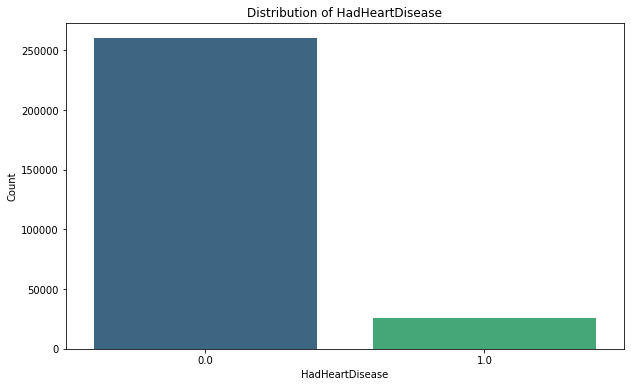

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'HadHeartDisease' column to a Pandas DataFrame
pandas_df = reduced_df.select('HadHeartDisease').toPandas()

# Plot the distribution of 'HadHeartDisease'
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_df, x='HadHeartDisease', palette='viridis')
plt.title('Distribution of HadHeartDisease')
plt.xlabel('HadHeartDisease')
plt.ylabel('Count')
plt.show()


In [30]:
from pyspark.sql import functions as F

# Separate the DataFrame into majority and minority classes
majority_class = reduced_df.filter(F.col('HadHeartDisease') == 0)  
minority_class = reduced_df.filter(F.col('HadHeartDisease') == 1)  

# Get the size of the minority class
minority_count = minority_class.count()

# Downsample the majority class to match the size of the minority class
majority_class_downsampled = majority_class.sample(False, float(minority_count) / majority_class.count())

balanced_df = majority_class_downsampled.union(minority_class)

# Verify the balance
balanced_df.groupBy('HadHeartDisease').count().show()


+---------------+-----+
|HadHeartDisease|count|
+---------------+-----+
|            0.0|25436|
|            1.0|25459|
+---------------+-----+



In [31]:
balanced_df.printSchema()


root
 |-- SleepHours: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- Sex: double (nullable = false)
 |-- PhysicalActivities: double (nullable = false)
 |-- HadStroke: double (nullable = false)
 |-- HadAsthma: double (nullable = false)
 |-- HadSkinCancer: double (nullable = false)
 |-- HadCOPD: double (nullable = false)
 |-- HadDepressiveDisorder: double (nullable = false)
 |-- HadKidneyDisease: double (nullable = false)
 |-- HadArthritis: double (nullable = false)
 |-- AlcoholDrinkers: double (nullable = false)
 |-- HIVTesting: double (nullable = false)
 |-- FluVaxLast12: double (nullable = false)
 |-- PneumoVaxEver: double (nullable = false)
 |-- HadHeartDisease: double (nullable = false)
 |-- Smoked: double (nullable = false)
 |-- Diabetic: double (nullable = false)
 |-- AgeCategory: double (nullable = false)
 |-- RaceEth: double (nullable = false)



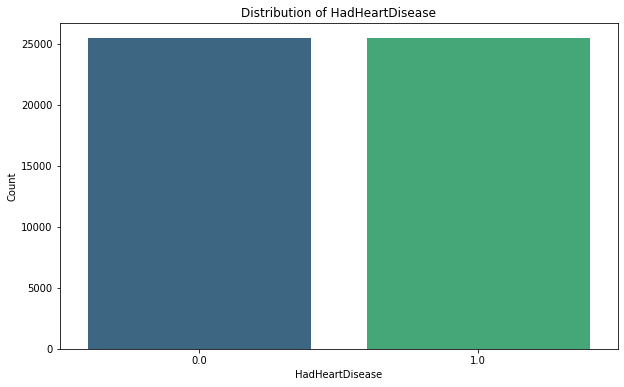

In [32]:
pandas_df = balanced_df.select('HadHeartDisease').toPandas()

# Plot the distribution of 'HadHeartDisease'
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_df, x='HadHeartDisease', palette='viridis')
plt.title('Distribution of HadHeartDisease')
plt.xlabel('HadHeartDisease')
plt.ylabel('Count')
plt.show()

In [33]:
num_columns = len(balanced_df.columns)
print(f"The number of columns in the balanced DataFrame is: {num_columns}")

The number of columns in the balanced DataFrame is: 20


In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Combine all features into a single vector column
feature_columns = [col for col in balanced_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(balanced_df)

# Split the data into training and testing sets
(train_df, test_df) = formatted_df.randomSplit([0.8, 0.2])

# Fit the RandomForestClassifier
rf = RandomForestClassifier(labelCol='HadHeartDisease', featuresCol='features', numTrees=100)
rf_model = rf.fit(train_df)

# Make predictions on the test set
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='HadHeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of RandomForestClassifier: {accuracy:.4f}")

auc_evaluator = BinaryClassificationEvaluator(labelCol='HadHeartDisease', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)
print(f"AUC of RandomForestClassifier: {auc:.4f}")

# Extract Feature Importances
importances = rf_model.featureImportances
feature_importances = sorted(zip(importances, feature_columns), reverse=True)

# Display Feature Importances in descending order
print("Feature Importance:")
for importance, feature in feature_importances:
    print(f"{feature}: {importance:.4f}")


Accuracy of RandomForestClassifier: 0.7291


AUC of RandomForestClassifier: 0.8065
Feature Importance:
AgeCategory: 0.3783
PneumoVaxEver: 0.1608
HadArthritis: 0.1058
HadStroke: 0.0970
Diabetic: 0.0831
HadCOPD: 0.0775
Sex: 0.0307
Smoked: 0.0226
HadKidneyDisease: 0.0218
PhysicalActivities: 0.0082
AlcoholDrinkers: 0.0062
HadSkinCancer: 0.0025
FluVaxLast12: 0.0023
SleepHours: 0.0015
BMI: 0.0007
HadDepressiveDisorder: 0.0004
HadAsthma: 0.0002
HIVTesting: 0.0002
RaceEth: 0.0001


In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Combine all features into a single vector column
feature_columns = [col for col in balanced_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(balanced_df)

# Split the data into training and testing sets
(train_df, test_df) = formatted_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='HadHeartDisease', featuresCol='features')
dt_model = dt.fit(train_df)

# Make predictions on the test set
predictions = dt_model.transform(test_df)

# Evaluate the model's accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='HadHeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy of DecisionTreeClassifier: {accuracy:.4f}")

# Evaluate the model's AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol='HadHeartDisease', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)
print(f"AUC of DecisionTreeClassifier: {auc:.4f}")

# Extract Feature Importances
importances = dt_model.featureImportances
feature_importances = sorted(zip(importances, feature_columns), reverse=True)

# Display Feature Importances in descending order
print("Feature Importance:")
for importance, feature in feature_importances:
    print(f"{feature}: {importance:.4f}")


Accuracy of DecisionTreeClassifier: 0.7125


AUC of DecisionTreeClassifier: 0.6822
Feature Importance:
AgeCategory: 0.6844
Diabetic: 0.1039
HadCOPD: 0.0707
HadArthritis: 0.0695
HadStroke: 0.0407
Sex: 0.0308
Smoked: 0.0000
SleepHours: 0.0000
RaceEth: 0.0000
PneumoVaxEver: 0.0000
PhysicalActivities: 0.0000
HadSkinCancer: 0.0000
HadKidneyDisease: 0.0000
HadDepressiveDisorder: 0.0000
HadAsthma: 0.0000
HIVTesting: 0.0000
FluVaxLast12: 0.0000
BMI: 0.0000
AlcoholDrinkers: 0.0000


In [36]:

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator


# Combine all features into a single vector column
feature_columns = [col for col in balanced_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(balanced_df)

# Split the data into training and testing sets
(train_df, test_df) = formatted_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol='HadHeartDisease', featuresCol='features', maxIter=100)
gbt_model = gbt.fit(train_df)

# Make predictions on the test set
predictions = gbt_model.transform(test_df)

# Evaluate the model's accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='HadHeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy of Gradient-Boosted Tree Classifier: {accuracy:.4f}")

# Evaluate the model's AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol='HadHeartDisease', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)
print(f"AUC of Gradient-Boosted Tree Classifier: {auc:.4f}")

# Extract Feature Importances
importances = gbt_model.featureImportances
feature_importances = sorted(zip(importances, feature_columns), key=lambda x: x[0], reverse=True)

# Display Feature Importances in descending order
print("Feature Importance:")
for importance, feature in feature_importances:
    print(f"{feature}: {importance:.4f}")


24/05/20 02:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1000.2 KiB
24/05/20 02:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
24/05/20 02:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
24/05/20 02:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
24/05/20 02:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1008.2 KiB
24/05/20 02:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
24/05/20 02:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
24/05/20 02:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
24/05/20 02:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB
24/05/20 02:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
24/05/20 02:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
24/05/20 02:11:46 WAR

Accuracy of Gradient-Boosted Tree Classifier: 0.7476


24/05/20 02:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1079.4 KiB


AUC of Gradient-Boosted Tree Classifier: 0.8191
Feature Importance:
AgeCategory: 0.2870
BMI: 0.0718
HadKidneyDisease: 0.0680
SleepHours: 0.0635
HadArthritis: 0.0622
Smoked: 0.0600
PneumoVaxEver: 0.0554
HadStroke: 0.0464
Sex: 0.0449
RaceEth: 0.0443
Diabetic: 0.0406
HadCOPD: 0.0371
AlcoholDrinkers: 0.0297
HadDepressiveDisorder: 0.0293
PhysicalActivities: 0.0243
HadAsthma: 0.0115
HadSkinCancer: 0.0103
FluVaxLast12: 0.0075
HIVTesting: 0.0060


In [37]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

feature_columns = [col for col in balanced_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(balanced_df)

# Split the data into training and testing sets
(train_df, test_df) = formatted_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the Logistic Regression model
lr = LogisticRegression(labelCol='HadHeartDisease', featuresCol='features', maxIter=100)
lr_model = lr.fit(train_df)

# Make predictions on the test set
predictions = lr_model.transform(test_df)

# Evaluate the model's accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='HadHeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy of Logistic Regression: {accuracy:.4f}")

# Evaluate the model's AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol='HadHeartDisease', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)
print(f"AUC of Logistic Regression: {auc:.4f}")

# Extract Feature Coefficients
coefficients = lr_model.coefficients.toArray()
intercept = lr_model.intercept

# Display Feature Coefficients
print("Feature Coefficients:")
for feature, coefficient in zip(feature_columns, coefficients):
    print(f"{feature}: {coefficient:.4f}")
print(f"Intercept: {intercept:.4f}")


Accuracy of Logistic Regression: 0.7261


AUC of Logistic Regression: 0.8008
Feature Coefficients:
SleepHours: -0.0049
BMI: -0.0004
Sex: 0.7911
PhysicalActivities: 0.3184
HadStroke: 1.4189
HadAsthma: -0.0167
HadSkinCancer: 0.4477
HadCOPD: 0.7468
HadDepressiveDisorder: 0.1073
HadKidneyDisease: 0.8290
HadArthritis: 0.5686
AlcoholDrinkers: 0.3862
HIVTesting: -0.1992
FluVaxLast12: -0.0914
PneumoVaxEver: 0.6870
Smoked: 0.3949
Diabetic: 0.6698
AgeCategory: -0.0970
RaceEth: -0.0367
Intercept: -1.4434


In [38]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Combine all features into a single vector column
feature_columns = [col for col in balanced_df.columns if col != 'HadHeartDisease']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
formatted_df = assembler.transform(balanced_df)

# Split the data into training and testing sets
(train_df, test_df) = formatted_df.randomSplit([0.8, 0.2], seed=1234)

# Fit the Naive Bayes model
nb = NaiveBayes(labelCol='HadHeartDisease', featuresCol='features')
nb_model = nb.fit(train_df)

# Make predictions on the test set
predictions = nb_model.transform(test_df)

# Evaluate the model's accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='HadHeartDisease', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy of Naive Bayes: {accuracy:.4f}")

# Evaluate the model's AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol='HadHeartDisease', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = auc_evaluator.evaluate(predictions)
print(f"AUC of Naive Bayes: {auc:.4f}")



24/05/20 02:34:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Accuracy of Naive Bayes: 0.6812


AUC of Naive Bayes: 0.4241
